In [1]:
import urllib.request
import matplotlib.pyplot as plt
import os
import glob
from skimage.feature import hog
import cv2
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.applications.vgg16 import VGG16

%matplotlib inline

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urllib.request.urlretrieve(url, file)
        print('Download Finished')
        
    else:
        print("File exists '{}' - skipping".format(file))


def draw_side_by_side(*images):
    cols = len(images)

    f, axes = plt.subplots(1, cols, figsize=(16, 6))
    f.tight_layout()
    f.subplots_adjust(left=-0.2, right=1, top=1., bottom=0., wspace=0., hspace=0.)

    if cols == 1:
        axes = [axes]

    for i in range(0,cols):
        a = axes[i]
        a.axis('off')
        a.imshow(images[i])

In [3]:
def get_test_images():
    images = glob.glob('data_sample/**/*.jpeg', recursive=True)
    print('images', len(images))
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
    return cars, notcars


car_files, notcar_files = get_test_images()

images 2321


In [6]:
def load_images(filenames):
    return [plt.imread(f) for f in filenames]


car_images = load_images(car_files)
notcar_images = load_images(notcar_files)

print('images loaded')

images loaded


In [7]:

print('car shape: ', car_images[0].shape)
print('notcar shape: ', notcar_images[0].shape)
print('Num cars: ', len(car_images))
print('Num notcars: ', len(notcar_images))
print('dtype: ', car_images[0].dtype)

car shape:  (64, 64, 3)
notcar shape:  (64, 64, 3)
Num cars:  1196
Num notcars:  1125
dtype:  uint8


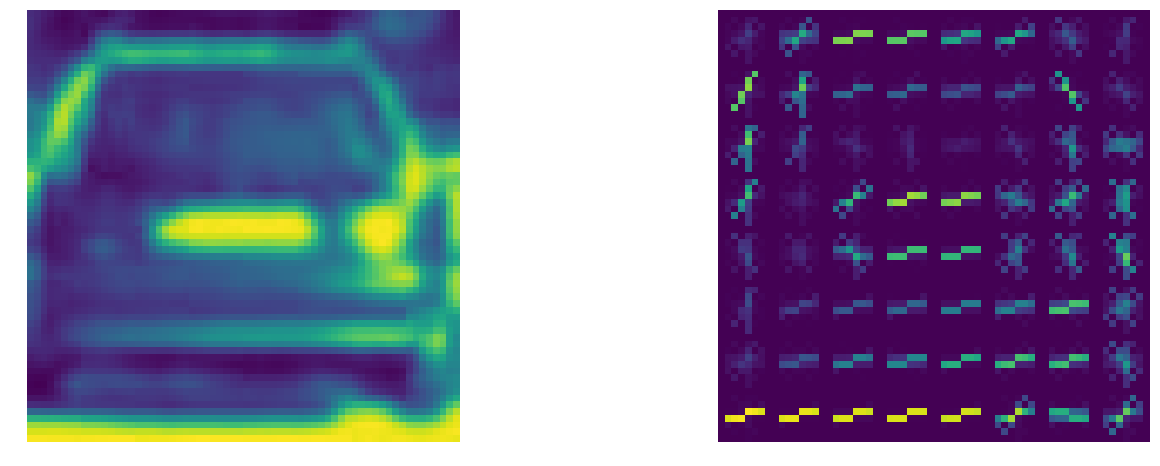

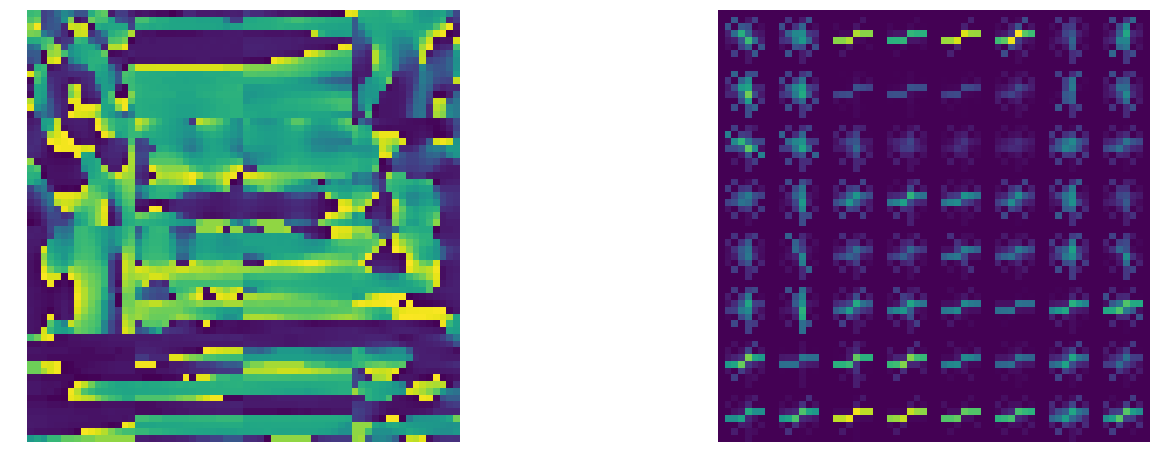

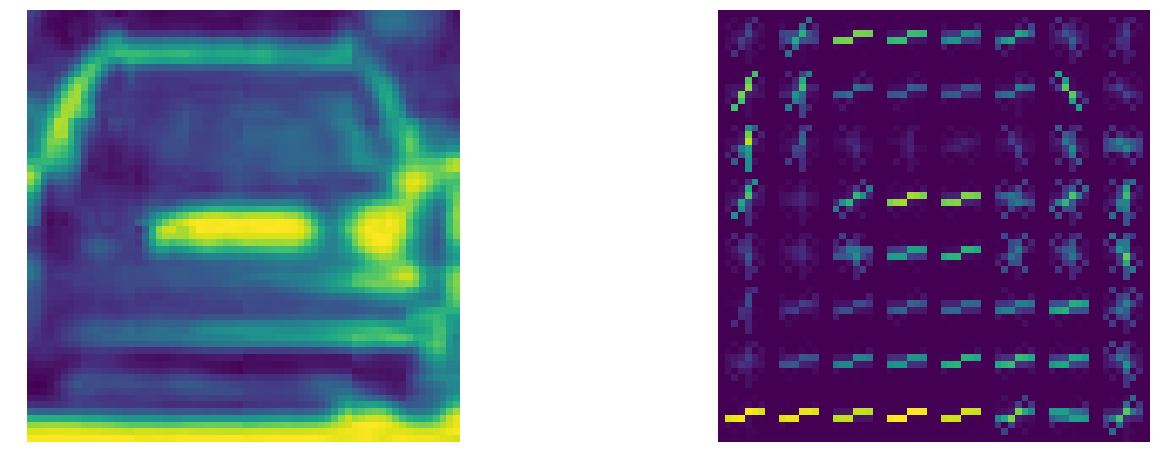

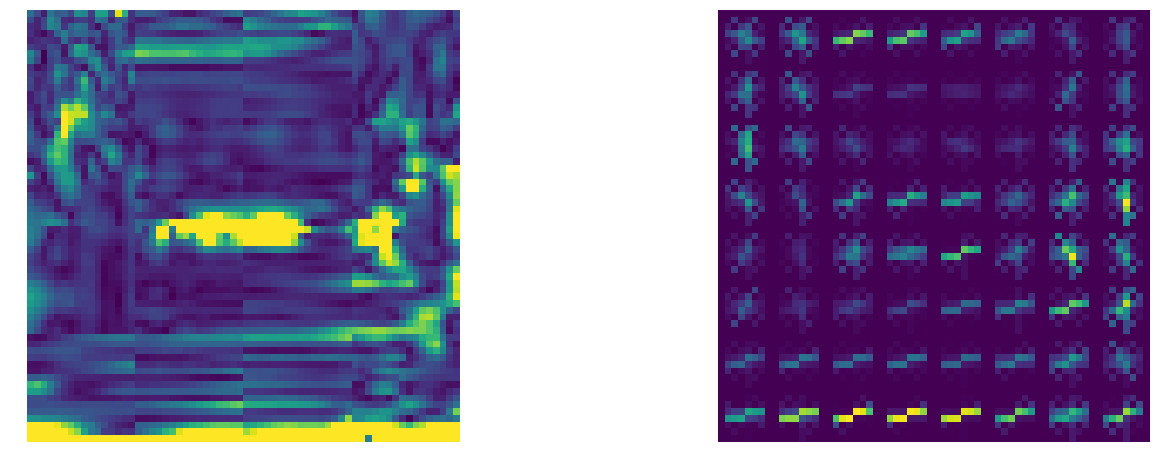

In [8]:
# Define a function to return HOG features and visualization
orient=9
pix_per_cell=8
cell_per_block=2


def image_to_hog(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=True, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block),
                      visualise=False, feature_vector=feature_vec,
                      block_norm="L2-Hys")
        return features


gray = cv2.cvtColor(car_images[0], cv2.COLOR_RGB2GRAY)
hog_gray = image_to_hog(gray, 9, 8, 2, vis=True)[1]

hls = cv2.cvtColor(car_images[0], cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]

hog_h = image_to_hog(h, 9, 8, 2, vis=True)[1]
hog_l = image_to_hog(l, 9, 8, 2, vis=True)[1]
hog_s = image_to_hog(s, 9, 8, 2, vis=True)[1]

draw_side_by_side(gray, hog_gray)
draw_side_by_side(h, hog_h)
draw_side_by_side(l, hog_l)
draw_side_by_side(s, hog_s)



I will choose the L channel for HOG gradients as the car stands out most in that channel.



# Preprocessing the images for training




In [36]:
def images_to_hogs(images, orient=10, pix_per_cell=16, cell_per_block=2, color_space='LUV', color_chan='ALL'):
    features_list = []
    for image in images:
        if color_space == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if color_space == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        if color_space == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        if color_space == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        if color_space == 'YCrCb':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

        if color_chan == 'ALL':
            image_hog = []
            for chan in range(image.shape[2]):
                chan_hog = image_to_hog(image[:, :, chan],
                                        orient,
                                        pix_per_cell,
                                        cell_per_block,
                                        vis=False, feature_vec=True)
                image_hog.append(chan_hog)
            image_hog = np.ravel(image_hog)

        else:
            image_hog = image_to_hog(image[:, :, color_chan],
                                     orient,
                                     pix_per_cell,
                                     cell_per_block,
                                     vis=False, feature_vec=True)

        features_list.append(image_hog)

    return features_list


def preprocess_data(car_images, notcar_images, **kwargs):
    print(kwargs)

    car_hogs = images_to_hogs(car_images, **kwargs)
    notcar_hogs = images_to_hogs(notcar_images, **kwargs)

    X = np.vstack((car_hogs, notcar_hogs)).astype(np.float64)
    y = np.hstack((np.ones(len(car_hogs)), np.zeros(len(notcar_hogs))))
    
    print(X.shape)
    return X, y


def train_svm(car_images, notcar_images, **kwargs):
    X, y = preprocess_data(car_images, notcar_images, **kwargs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    print('X_train.shape: ', X_train.shape)
    
    svc = SVC(C=1.0, kernel='linear')
    svc.fit(X_train, y_train)
    print('Test acc:', round(svc.score(X_test, y_test), 4))
    print('')
    
    return svc, X_scaler


In [37]:
# train_svm(car_images, notcar_images, orient=7, pix_per_cell=8, cell_per_block=2, color_space='RGB', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=8, pix_per_cell=8, cell_per_block=2, color_space='HLS', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='HSV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=11, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan='ALL')

{'pix_per_cell': 8, 'color_space': 'LUV', 'orient': 10, 'cell_per_block': 2, 'color_chan': 'ALL'}
(2321, 5880)
X_train.shape:  (1856, 5880)
Test acc: 0.9914



(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 StandardScaler(copy=True, with_mean=True, with_std=True))

### Color space choice
I will choose LUV as the color space

In [15]:
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=0)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=1)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=2)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=0)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=1)
train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=2)

{'pix_per_cell': 8, 'color_space': 'LUV', 'orient': 9, 'cell_per_block': 2, 'color_chan': 0}
(2321, 1764)
Test acc: 0.9505

{'pix_per_cell': 8, 'color_space': 'LUV', 'orient': 9, 'cell_per_block': 2, 'color_chan': 1}
(2321, 1764)
Test acc: 0.9548

{'pix_per_cell': 8, 'color_space': 'LUV', 'orient': 9, 'cell_per_block': 2, 'color_chan': 2}
(2321, 1764)
Test acc: 0.9699

{'pix_per_cell': 8, 'color_space': 'YCrCb', 'orient': 9, 'cell_per_block': 2, 'color_chan': 0}
(2321, 1764)
Test acc: 0.9527

{'pix_per_cell': 8, 'color_space': 'YCrCb', 'orient': 9, 'cell_per_block': 2, 'color_chan': 1}
(2321, 1764)
Test acc: 0.9656

{'pix_per_cell': 8, 'color_space': 'YCrCb', 'orient': 9, 'cell_per_block': 2, 'color_chan': 2}
(2321, 1764)
Test acc: 0.9656



(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 StandardScaler(copy=True, with_mean=True, with_std=True))

### Color channel choice

It looks like using all three channels gives better accuracy

In [15]:
# train_svm(car_images, notcar_images, orient=7, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=8, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=11, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')

### Number of orients choice

It looks like more orients are better, however the difference levels off at 10. I will choose 10 as any more might be succeptible to overfitting.


In [16]:
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=4, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=16, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=32, cell_per_block=2, color_space='LUV', color_chan='ALL')


### Pixels per cell
I will choose 16 - higher than 8 - as I believe it will help reduce the number of features, which should help reduce overfitting. 

In [11]:
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=1, color_space='LUV', color_chan='ALL')
train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=4, color_space='LUV', color_chan='ALL')

{'pix_per_cell': 8, 'color_space': 'LUV', 'orient': 10, 'cell_per_block': 2, 'color_chan': 'ALL'}
(2321, 5880)
Test acc: 0.9914



(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 StandardScaler(copy=True, with_mean=True, with_std=True))

### Cell per block choice
I will choose 2 cells per block

In [12]:
X, y = preprocess_data(car_images, notcar_images, orient=10, pix_per_cell=16, cell_per_block=2, color_space='LUV', color_chan='ALL')

{'pix_per_cell': 16, 'color_space': 'LUV', 'orient': 10, 'cell_per_block': 2, 'color_chan': 'ALL'}
(2321, 1080)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Set the parameters by cross-validation
tuned_parameters = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

print("# Tuning hyper-parameters")
print()

clf = GridSearchCV(SVC(), tuned_parameters, cv=3)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('Final Acc:', clf.score(X_test, y_test))


# Tuning hyper-parameters

Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Grid scores on development set:
0.983 (+/-0.008) for {'C': 1, 'kernel': 'linear'}
0.983 (+/-0.008) for {'C': 10, 'kernel': 'linear'}
0.983 (+/-0.008) for {'C': 100, 'kernel': 'linear'}
0.983 (+/-0.008) for {'C': 1000, 'kernel': 'linear'}
0.981 (+/-0.012) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.020) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.987 (+/-0.006) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.005) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.986 (+/-0.008) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.007) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.986 (+/-0.008) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.007) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Final Acc: 0.997849462366



### Hyperparams Tuning
I will stay with linear kernel with C=1.0

In [18]:
model_params = {
    'orient': 10,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'color_space': 'LUV',
    'color_chan': 'ALL' 
}

model, scaler = train_svm(car_images, notcar_images, **model_params)

{'pix_per_cell': 8, 'color_space': 'LUV', 'orient': 10, 'cell_per_block': 2, 'color_chan': 'ALL'}
(2321, 5880)
Test acc: 0.9914



In [63]:
def is_car(window_pixels):
    window_pixels_resized = cv2.resize(window_pixels, (model_size, model_size))
#     window_pixels_resized = window_pixels

    hogs = images_to_hogs([window_pixels_resized], **model_params)
    window_X = np.vstack(hogs)
    window_X = scaler.transform(window_X)
    pred = model.predict(window_X)[0]
    
#     print(window_pixels.shape)
#     print(window_pixels_resized.shape)
#     print(window_X.shape)
#     print(pred)
    return bool(pred)

# draw_side_by_side(car_images[0], notcar_images[0])

is_car(car_images[0])
is_car(car_images[1])
is_car(car_images[2])
is_car(car_images[3])

is_car(notcar_images[0])
is_car(notcar_images[1])
is_car(notcar_images[2])
is_car(notcar_images[3])

False

# CNN model

I will try to use transfer learning with VGG16 (as I have used it before) to detect car and non-car images.

In [19]:
model_vgg16 = VGG16(include_top=False, 
                    weights='imagenet',
                    input_shape=car_images[0].shape)

model_vgg16.add(Dense(1000))



# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(...)

AttributeError: 'Model' object has no attribute 'add'

# Window search

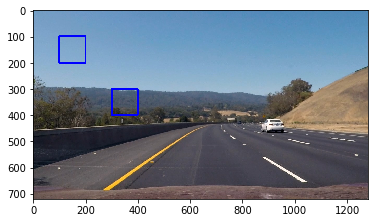

In [80]:
test3 = plt.imread('test_images/test3.jpg')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for x, y in bboxes:
        cv2.rectangle(draw_img, x, y, color, thick)
    return draw_img 

bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]

result = draw_boxes(test3, bboxes)
plt.imshow(result)

(720, 1280, 3)


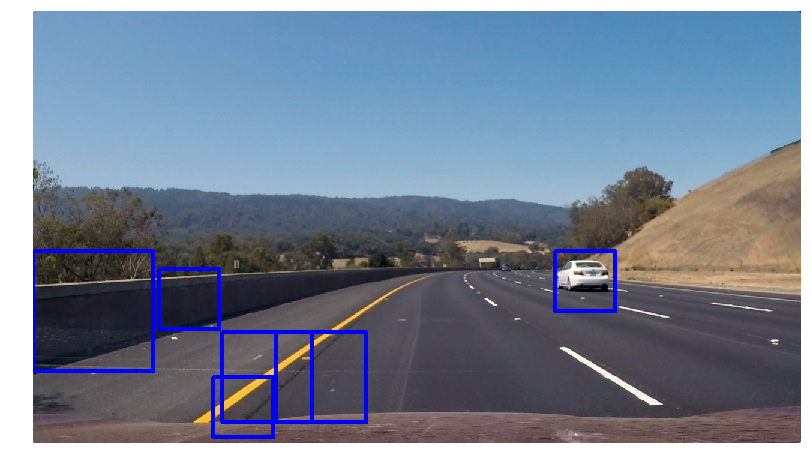

In [92]:
def image_to_locations(image):
    width = 1280
    height = 720
    start_height = 400
    window_step_frac = 0.3
    model_size = 64

    locations = []
    for window_size in [100, 150, 200]:
        window_step = round(window_size * window_step_frac)
        for y in range(start_height, height-window_size, window_step):
            for x in range(0, width-window_size, window_step):

                window_pixels = image[y:y+window_size, x:x+window_size, :]
                if is_car(window_pixels):
                    locations.append( 
                        ((x, y), (x+window_size, y+window_size))
                    )
    return locations

test3 = plt.imread('test_images/test3.jpg')
print(test3.shape)

locations = image_to_locations(test3)
image_with_car_boxes = draw_boxes(test3, locations)
draw_side_by_side(image_with_car_boxes)

        


In [ ]:

test3 = plt.imread('test_images/test1.jpg')
print(test3.shape)

locations = image_to_locations(test3)
image_with_car_boxes = draw_boxes(test3, locations)
draw_side_by_side(image_with_car_boxes)

(720, 1280, 3)


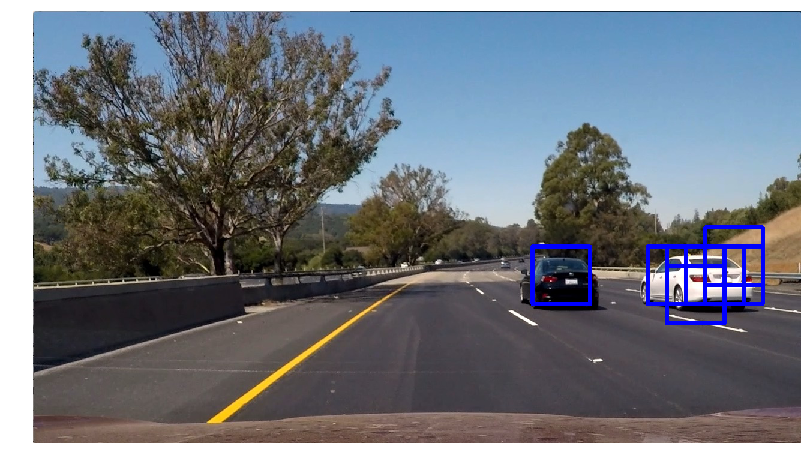

In [87]:

test3 = plt.imread('test_images/test6.jpg')
print(test3.shape)

locations = image_to_locations(test3)
image_with_car_boxes = draw_boxes(test3, locations)
draw_side_by_side(image_with_car_boxes)

True


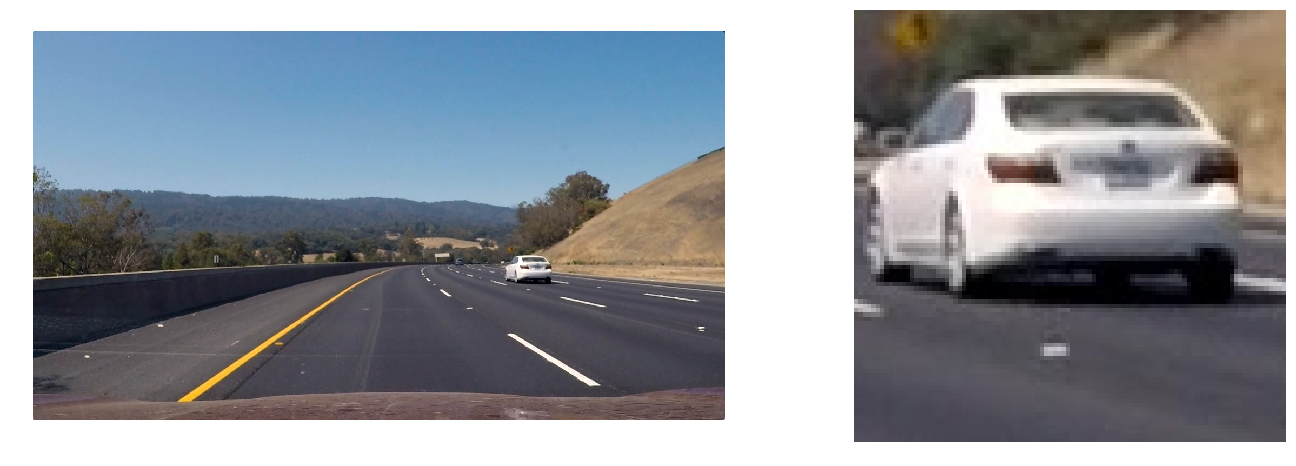

In [88]:
test3 = plt.imread('test_images/test3.jpg')
draw_side_by_side(test3, test3[400:500, 870:970])
print(is_car(test3[400:500, 870:970]))